# Loading libraries

In [23]:
import torch
import torch.nn as nn
from torch_snippets import *

from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, models, transforms
import os

from random import shuffle


device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
%matplotlib inline

# Class Activation Maps

In [2]:
### deleting extra files

In [5]:
base_dir = "5\\archive\\cell_images\\cell_images"

In [6]:
os.listdir(base_dir)

['Parasitized', 'Uninfected']

In [10]:
parasite_dir = os.path.join(base_dir,"Parasitized")
uninfected_dir = os.path.join(base_dir, "Uninfected")

In [14]:
def remove_extra(base_dir, max_files = 2000):
    files = os.listdir(base_dir)
    shuffle(files)
    
    
    for index in range(max_files, len(files)):
        os.remove(os.path.join(base_dir,files[index]))

In [17]:
# remove_extra(parasite_dir)
# remove_extra(uninfected_dir)

In [18]:
id2int = {'Parasitized':0, 'Uninfected':1}

In [24]:
### Last time, utilized augmentors
### library. This time will utilize pytorch transforms




In [28]:
trn_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(128),
        transforms.CenterCrop(128),  ## crops the image at center
        transforms.ColorJitter(brightness=(0.95,1.05),
                               contrast=(0.95,1.05),
                               saturation=(0.95,1.05),
                               hue=(0.05)),  ### randomly changes brightness, hue etc
        transforms.RandomAffine(5, translate=(0.01,0.01)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5,0.5,0.5],std=[0.5,0.5,0.5])
    ]
)

In [25]:
transforms.CenterCrop?

Init signature: transforms.CenterCrop(size)
Docstring:     
Crops the given image at the center.
If the image is torch Tensor, it is expected
to have [..., H, W] shape, where ... means an arbitrary number of leading dimensions.
If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.

Args:
    size (sequence or int): Desired output size of the crop. If size is an
        int instead of sequence like (h, w), a square crop (size, size) is
        made. If provided a sequence of length 1, it will be interpreted as (size[0], size[0]).
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           c:\users\rachi\anaconda3\lib\site-packages\torchvision\transforms\transforms.py
Type:           type
Subclasses:     


In [26]:
transforms.ColorJitter?

Init signature: transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
Docstring:     
Randomly change the brightness, contrast, saturation and hue of an image.
If the image is torch Tensor, it is expected
to have [..., 1 or 3, H, W] shape, where ... means an arbitrary number of leading dimensions.
If img is PIL Image, mode "1", "I", "F" and modes with transparency (alpha channel) are not supported.

Args:
    brightness (float or tuple of float (min, max)): How much to jitter brightness.
        brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
        or the given [min, max]. Should be non negative numbers.
    contrast (float or tuple of float (min, max)): How much to jitter contrast.
        contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
        or the given [min, max]. Should be non negative numbers.
    saturation (float or tuple of float (min, max)): How much to jitter saturation.
        saturation_

In [29]:
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    
])

In [188]:
class MalariaImages(Dataset):
    
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms
        
        logger.info(len(self))
        
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        fpath = self.files[index]
        # clss = fname(parent(fpath))  ## not working
        
        path = os.path.dirname(fpath) # directory component
        clss = os.path.basename(path)
        # print(fpath)
        img = read(fpath,1)
        return img, clss
    
    def choose(self):
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transforms:
            imgs = [self.transforms(img)[None] for img in _imgs]
        
        # print(classes)
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        
        return imgs, classes, _imgs
    
        

In [189]:
all_files = Glob(os.path.join(base_dir,'*','*.png'))

In [190]:
shuffle(all_files)

In [191]:
from sklearn.model_selection import train_test_split

In [192]:
trn_files, val_files = train_test_split(all_files)

In [193]:
trn_ds = MalariaImages(trn_files, transforms=trn_transforms)

[02/07/23 07:04:55] INFO     3000                                       ]8;id=995068;file://<ipython-input-188-441cc7c2f7a2>\<ipython-input-188-441cc7c2f7a2>]8;;\:]8;id=317061;file://<ipython-input-188-441cc7c2f7a2>#__init__:7\__init__:7]8;;\

In [194]:
val_ds = MalariaImages(val_files, transforms=val_transforms)

[02/07/23 07:04:56] INFO     1000                                       ]8;id=11472;file://<ipython-input-188-441cc7c2f7a2>\<ipython-input-188-441cc7c2f7a2>]8;;\:]8;id=551481;file://<ipython-input-188-441cc7c2f7a2>#__init__:7\__init__:7]8;;\

In [195]:
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

In [196]:
## Model class

def conv_block(ni, no, kernel_size = 3,stride=1, padding=1):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni,no,kernel_size=kernel_size,stride=stride, padding=padding),
        
        nn.BatchNorm2d(no),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2)
        
    )
    
    
class MalariaClassifier(nn.Module):
    
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            conv_block(3,64),
            conv_block(64,64),
            conv_block(64,128),
            conv_block(128,256),
            conv_block(256,512),
            conv_block(512,64),
            nn.Flatten(),
            nn.Linear(256,256),
            nn.Dropout(0.2),
            ## not same as book
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self,x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        
        acc = (torch.max(preds, 1)[1] == targets).float().mean()     
        return loss, acc
    

In [197]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()
    

In [198]:
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
     

In [199]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

n_epochs = 2


log = Report(n_epochs=n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer,criterion)
        log.record(ex+(bx+1)/N, trn_loss = loss, trn_acc = acc, end = '\r')
        
    
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        
        log.record(ex + (bx+1)/N, val_loss = loss, val_acc= acc, end = '\r')
        

    log.report_avgs(ex+1)
    
        

EPOCH: 1.000  val_acc: 0.899  trn_acc: 0.765  trn_loss: 0.470  val_loss: 0.294  (34.06s - 34.06s remaining)
EPOCH: 2.000  val_acc: 0.932  trn_acc: 0.945  trn_loss: 0.170  val_loss: 0.241  (48.90s - 0.00s remaining)


In [200]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))
     

In [201]:
im2fmap

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [202]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [203]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

torch.Size([1, 64, 4, 4])

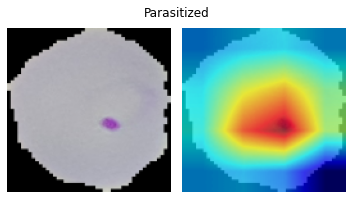

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

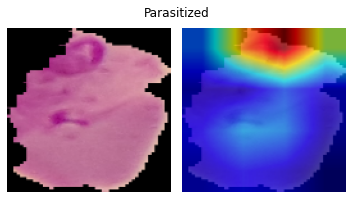

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

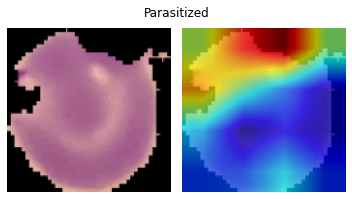

torch.Size([1, 64, 4, 4])

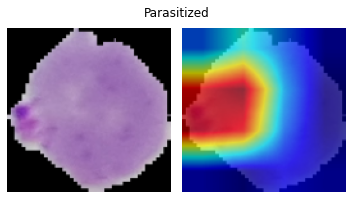

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

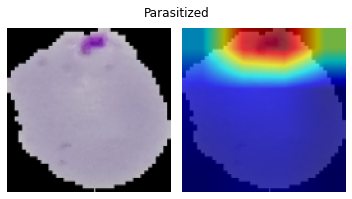

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

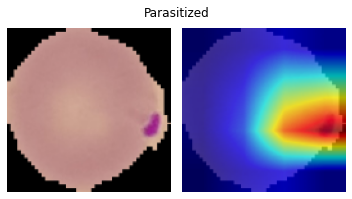

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

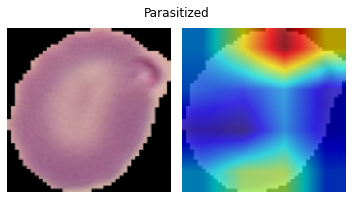

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

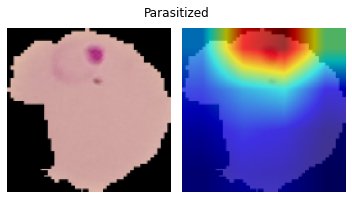

In [204]:

N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)

# Impact of Batch Normalization and Image Augmentation

1. Data Augmentation is a great way to control overfitting and improve the accuracy of our model

2. Batch Normalization also helps a lot as due to trainings, the weights multiplication of weights and inputs can lead to values that are not appropriate for the activation fn.

# Practical Aspects to take care of while doing Image Classification


Things to take care of:

1. Dealing with Imbalanced Data
2. Size of an object within an image.
3. Difference b.w training and validation images
4. Number of pooling and convolution layers in a network.
5. Image sizes to train on GPUs
6. Leveraging Open CV utilities.


### 1. Imbalanced Data

1. Don't rely on only accuracy. Use Confusion matrix or metrics like precision, recall, f1 score

2. To train this model:

        a) Assign weights to minority class, thereby specifying to the model that it needs to avoid making mistakes on minority class.

        b) Use Data Augmentation

        c) Use Transfer Learning

        d) Can oversample rare class

### 2. Size of an object


Use Object Detection instead of image classification

###  3. Difference b.w training and validation images

Ensure that training and real-world data have a simmilar data distribution before the system is used in real life scenarios

### 4. Number of nodes in flatten layer

Ideally, we should have 500 to 5000 nodes in the flatten layer.

Ideally should use transfer learning